Notebook purpose

- Perform entire analysis

todo:

- Trim variables?


- Explaining regression results:

    - Entropy doesn't capture what we want it to

    - Model is misspecified 
        - Deal with large number of zeros in y: Tobit / Heckman selection model / sth else?

        - Look into wide vs long panel
  

In [197]:
import contextlib
import math
import os
import re
import sys

import linearmodels as lm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabulate

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.analysis.make_analysis_data as ad
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.selectors as sl
import entropy.figures.figures as ff
import entropy.figures.helpers as fh
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [251]:
df = hd.read_analysis_data()
hd.inspect(df, nrows=5)

Time for read_analysis_data            : 1.57 seconds
(93,557, 25)


txn_count_sa  txn_count_ca  sa_inflows  sa_outflows  \
user_id date                                                              
37      2012-02-29           3.0           8.0      3340.0       1740.0   
        2012-03-31           2.0           9.0         0.0          0.0   
        2012-04-30           1.0           9.0         0.0       1500.0   
        2012-05-31           1.0          13.0      2848.5          0.0   
        2012-06-30           0.0          11.0         0.0          0.0   

                    sa_net_inflows  sa_scaled_inflows  sa_scaled_outflows  \
user_id date                                                                
37      2012-02-29          1600.0           2.135478            1.112494   
        2012-03-31             0.0           0.000000            0.000000   
        2012-04-30         -1500.0           0.000000            0.959047   
        2012-05-31          2848.5           1.821230            0.000000   
        2012-06-30             0.0           0.000000            0.000000   

                    sa_scaled_net_inflows  monthly_spend  log_monthly_spend  \
user_id date                                                                  
37      2012-02-29               1.022983     528.239990           6.269551   
        2012-03-31               0.000000     429.880005           6.063506   
        2012-04-30              -0.959047    1208.160034           7.096854   
        2012-05-31               1.821230     624.010010           6.436166   
        2012-06-30               0.000000     723.869995           6.584612   

                    prop_spend_services  prop_spend_household  \
user_id date                                                    
37      2012-02-29             0.224898              0.591852   
        2012-03-31             0.028799              0.761841   
        2012-04-30             0.048553              0.435530   
        2012-05-31             0.039214              0.770805   
        2012-06-30             0.038087              0.585754   

                    prop_spend_communication  prop_spend_other_spend  \
user_id date                                                           
37      2012-02-29                  0.094654                0.088596   
        2012-03-31                  0.116312                0.093049   
        2012-04-30                  0.000000                0.515917   
        2012-05-31                  0.104662                0.085319   
        2012-06-30                  0.090223                0.128476   

                    prop_spend_retail  prop_spend_finance  prop_spend_motor  \
user_id date                                                                  
37      2012-02-29           0.000000                 0.0               0.0   
        2012-03-31           0.000000                 0.0               0.0   
        2012-04-30           0.000000                 0.0               0.0   
        2012-05-31           0.000000                 0.0               0.0   
        2012-06-30           0.157459                 0.0               0.0   

                    prop_spend_travel  prop_spend_hobbies        income  \
user_id date                                                              
37      2012-02-29                0.0                 0.0  18768.632812   
        2012-03-31                0.0                 0.0  18768.632812   
        2012-04-30                0.0                 0.0  18768.632812   
        2012-05-31                0.0                 0.0  18768.632812   
        2012-06-30                0.0                 0.0  18768.632812   

                    log_income  female   age    region  entropy_sptac  
user_id date                                                           
37      2012-02-29    9.839942     0.0  27.0  Scotland       2.899397  
        2012-03-31    9.839942     0.0  27.0  Scotland       3.039149  
        2012-04-30    9.839942     0.0  27.0  Scotland       2.866587  

## Sample description

Sample selection - see paper

Number of unique users

In [3]:
df.index.get_level_values("user_id").nunique()

3495

Number of months we observe users for

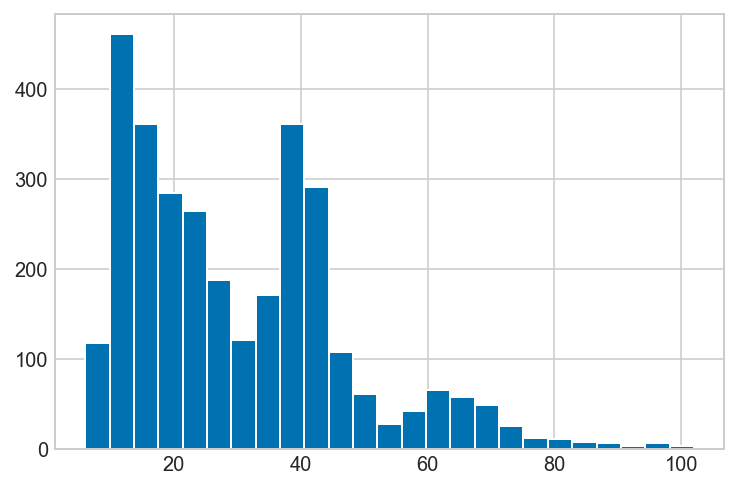

In [256]:
df.groupby("user_id").size().hist(bins=25);

User characteristics

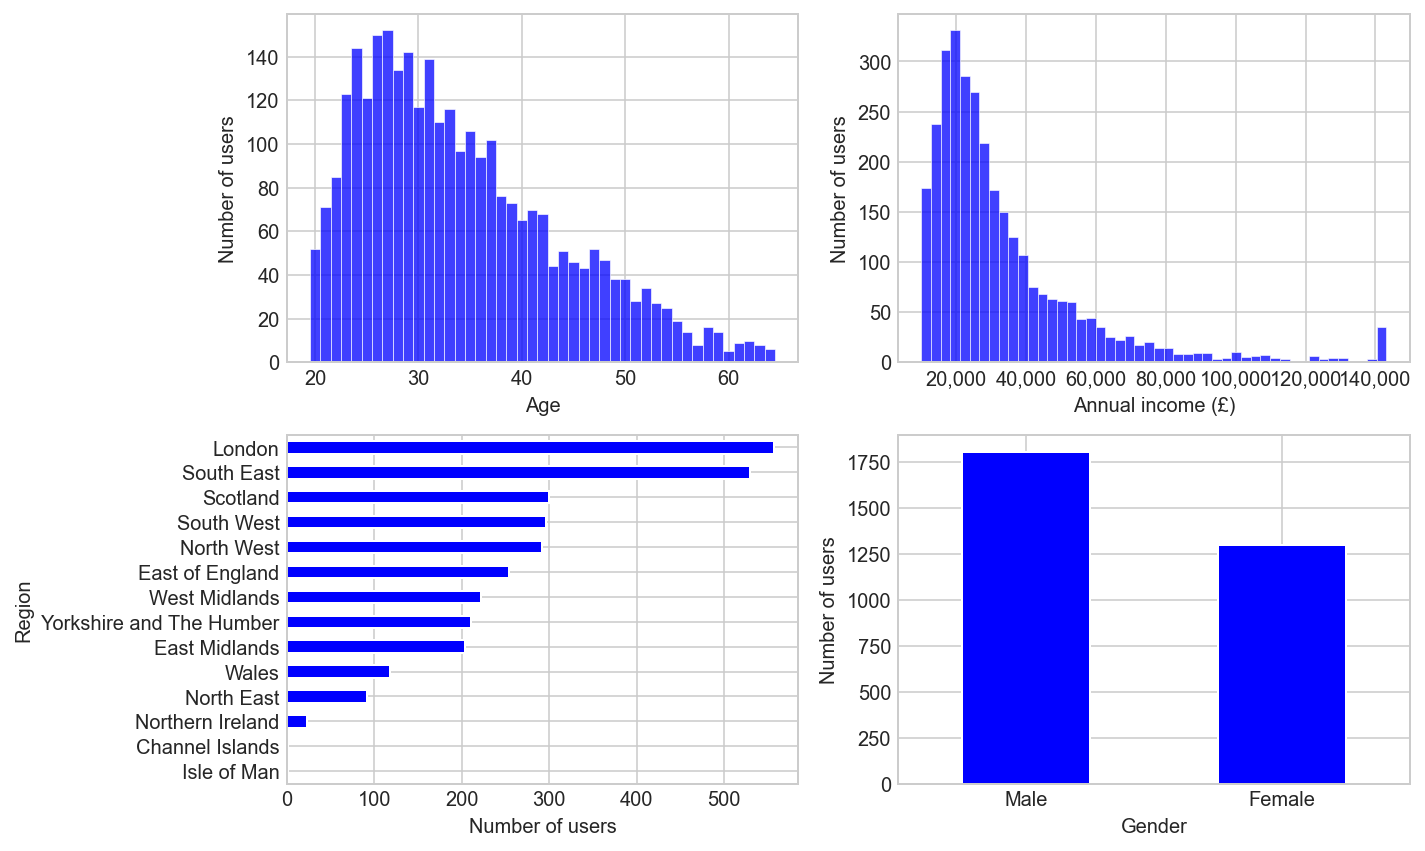

In [85]:
ff.sample_description(df, write=False)

## Summary statistics

In [232]:
import entropy.analysis.sumstats_table as ss

ss.main(df, write=False)

,count,mean,std,min,max,25%,50%,75%
txn_count_sa,93557.0,4.243798,8.519068,0.000000,3.890000e+02,0.000000,2.000000,5.000000
txn_count_ca,93557.0,92.854388,53.454898,2.000000,9.060000e+02,57.000000,82.000000,116.000000
sa_inflows,93557.0,1234.191284,24596.449219,0.000000,6.215068e+06,0.000000,5.440000,420.000000
sa_outflows,93557.0,1151.614502,18713.050781,0.000000,4.524177e+06,0.000000,0.000000,400.000000
sa_net_inflows,93557.0,82.576759,12216.861328,-705792.062500,1.690891e+06,0.000000,0.000000,70.000000
sa_scaled_inflows,93557.0,0.395806,4.463429,0.000000,6.456697e+02,0.000000,0.002437,0.180307
sa_scaled_outflows,93557.0,0.376805,3.267126,0.000000,3.875515e+02,0.000000,0.000000,0.171478
sa_scaled_net_inflows,93557.0,0.019000,4.716296,-387.468764,6.215899e+02,0.000000,0.000000,0.030515
monthly_spend,93557.0,2824.708008,5106.101074,200.529999,4.356753e+05,1174.839966,1885.040039,3164.840088
log_monthly_spend,93557.0,7.586336,0.767993,5.300964,1.298465e+01,7.068887,7.541704,8.059857


In [238]:
df.sa_scaled_inflows.pipe(hd.trim, how="upper").describe()

count    92621.000000
mean         0.199179
std          0.511948
min          0.000000
25%          0.000000
50%          0.000899
75%          0.170456
max          5.512925
Name: sa_scaled_inflows, dtype: float64

## Dependent variable - savings account inflows

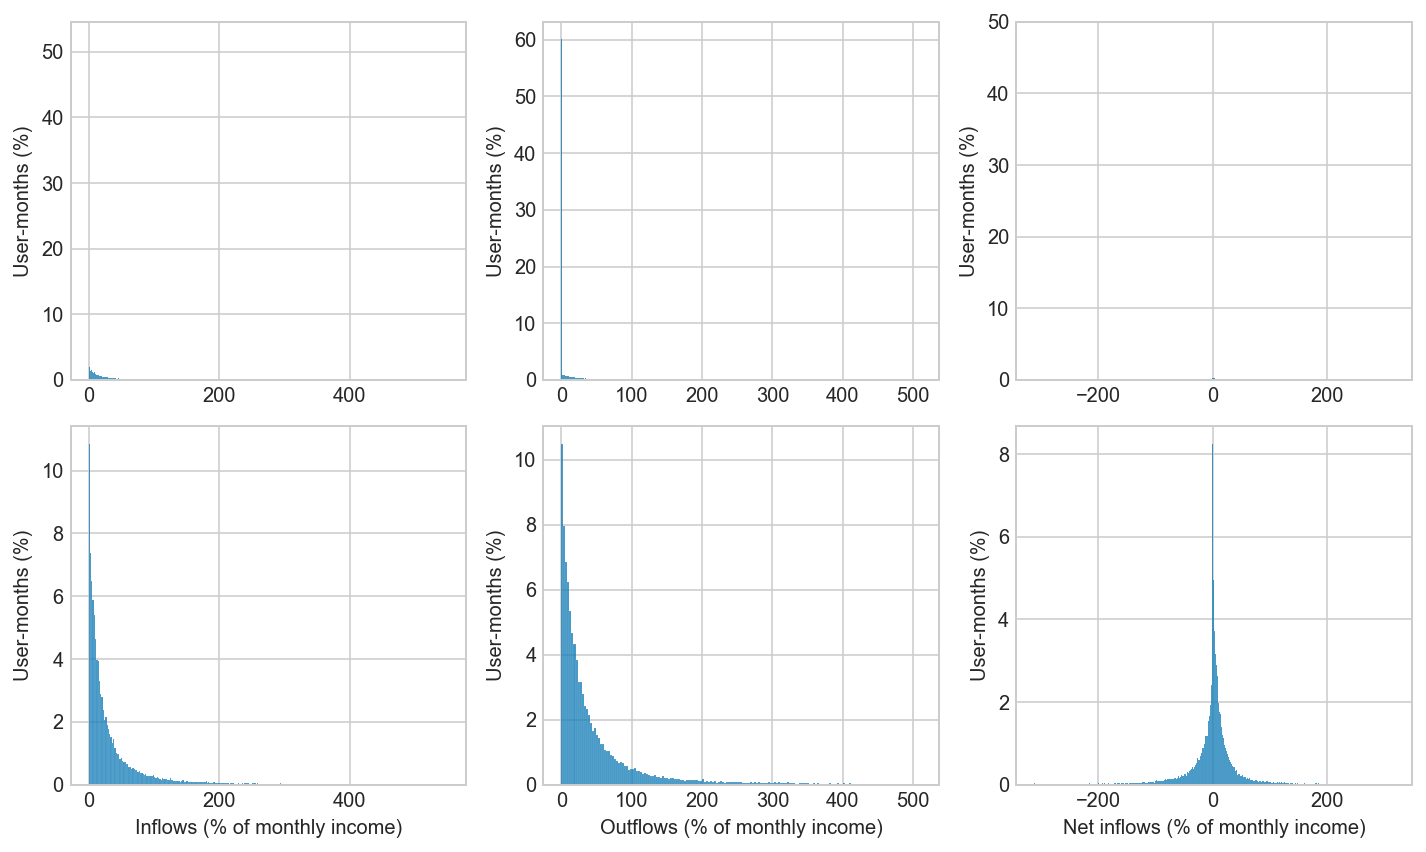

In [148]:
ff.monthly_savings(df);

## Independent variable - entropy

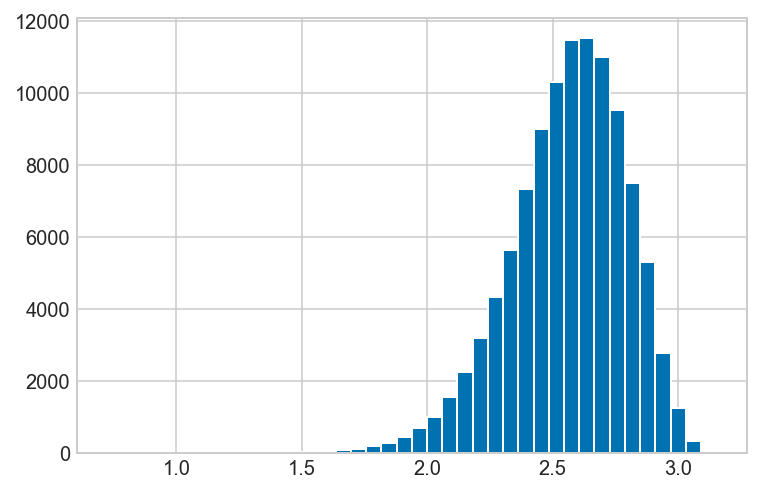

In [14]:
df.entropy_sptac.hist(bins=40);

Demystifying entropy calculation

In [211]:
def user_month_entropy(df):
    def _calc_entropy(probs):
        return -sum(p * math.log2(p) for p in probs)

    return df.apply(_calc_entropy, axis=1)


# d = hd.read_sample("777")
# cr.entropy_spend_tag_counts_partial(d)
# .pipe(user_month_entropy)
# .hist(bins=40)

## Correlations

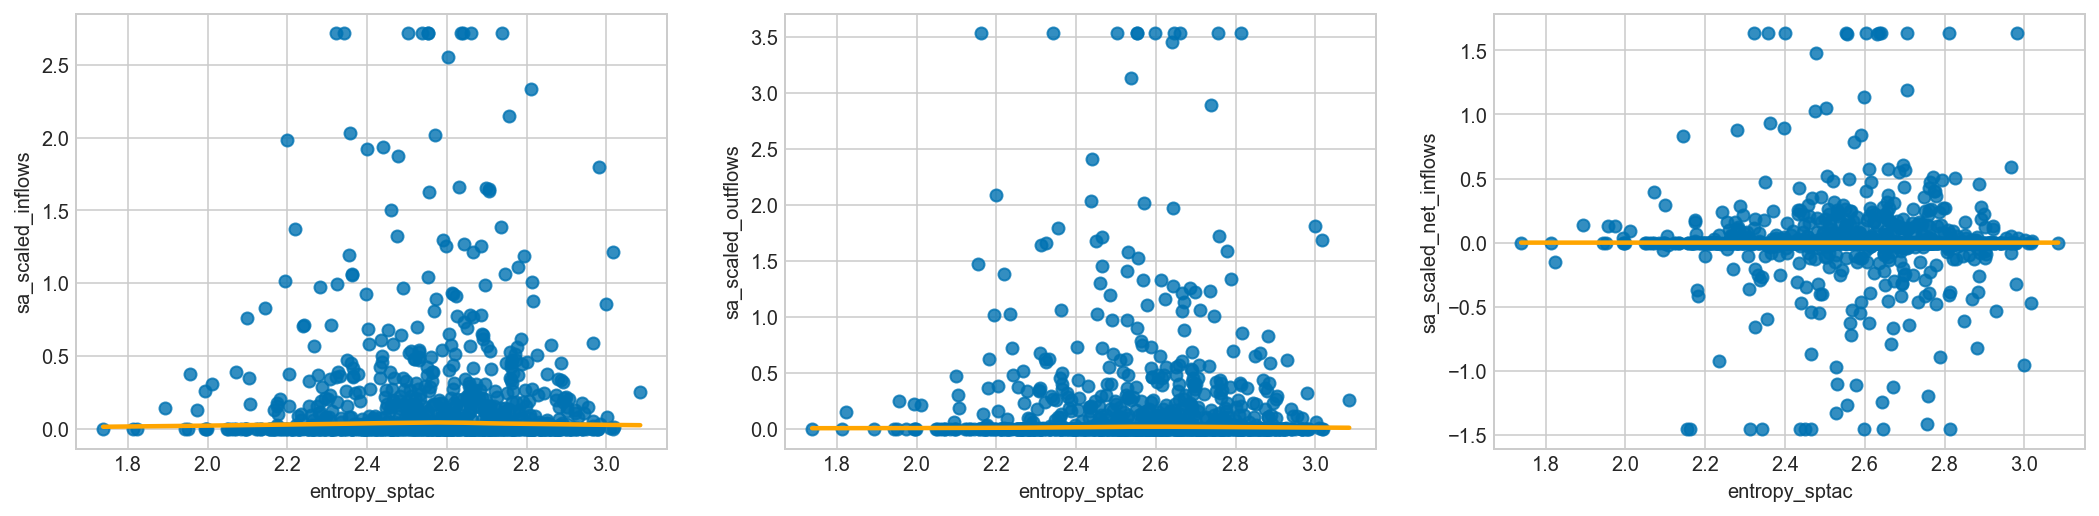

In [225]:
ff.regplot(df, "sa_scaled", "entropy", winsorise_kws=dict(pct=1))

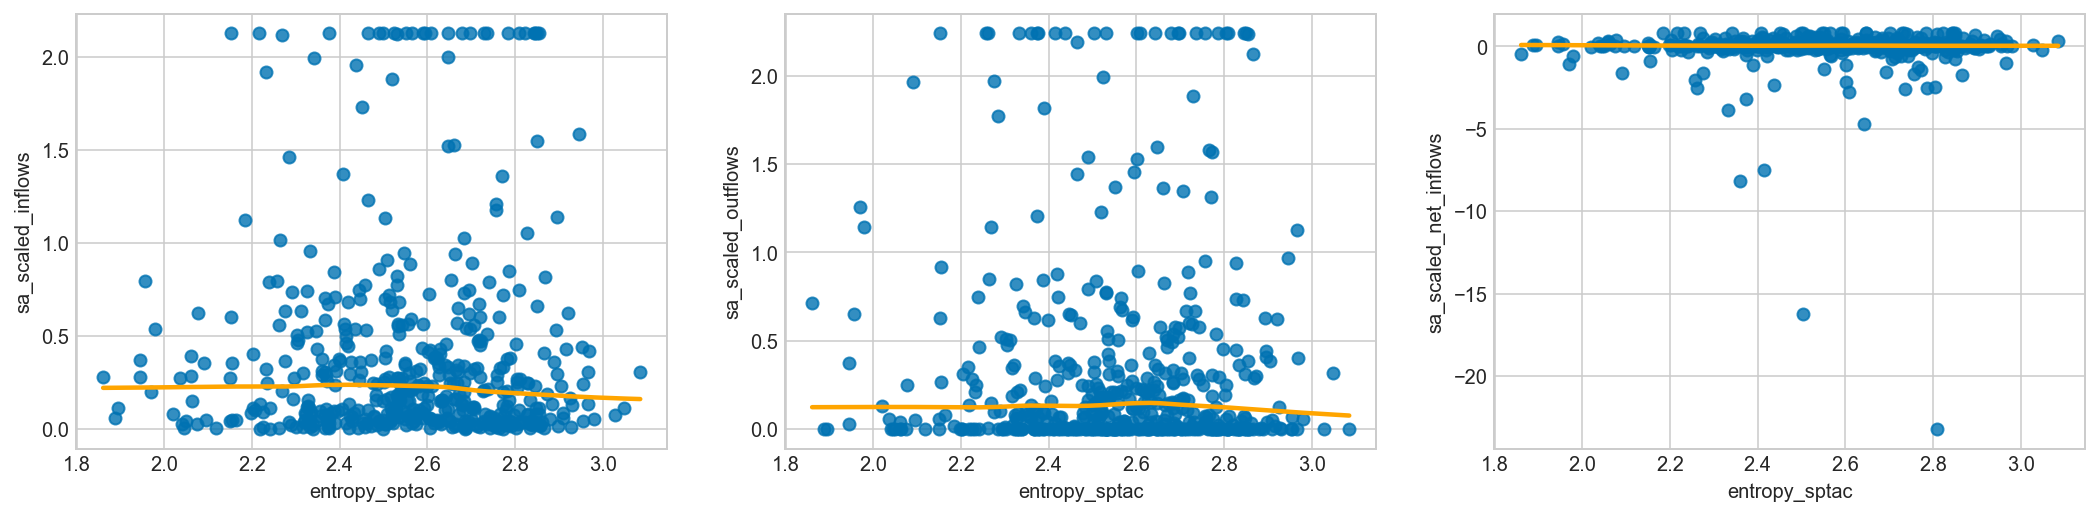

In [231]:
ff.regplot(
    df[df.sa_scaled_inflows.gt(0)],
    "sa_scaled",
    "entropy",
    winsorise_kws=dict(pct=5, how="upper"),
)

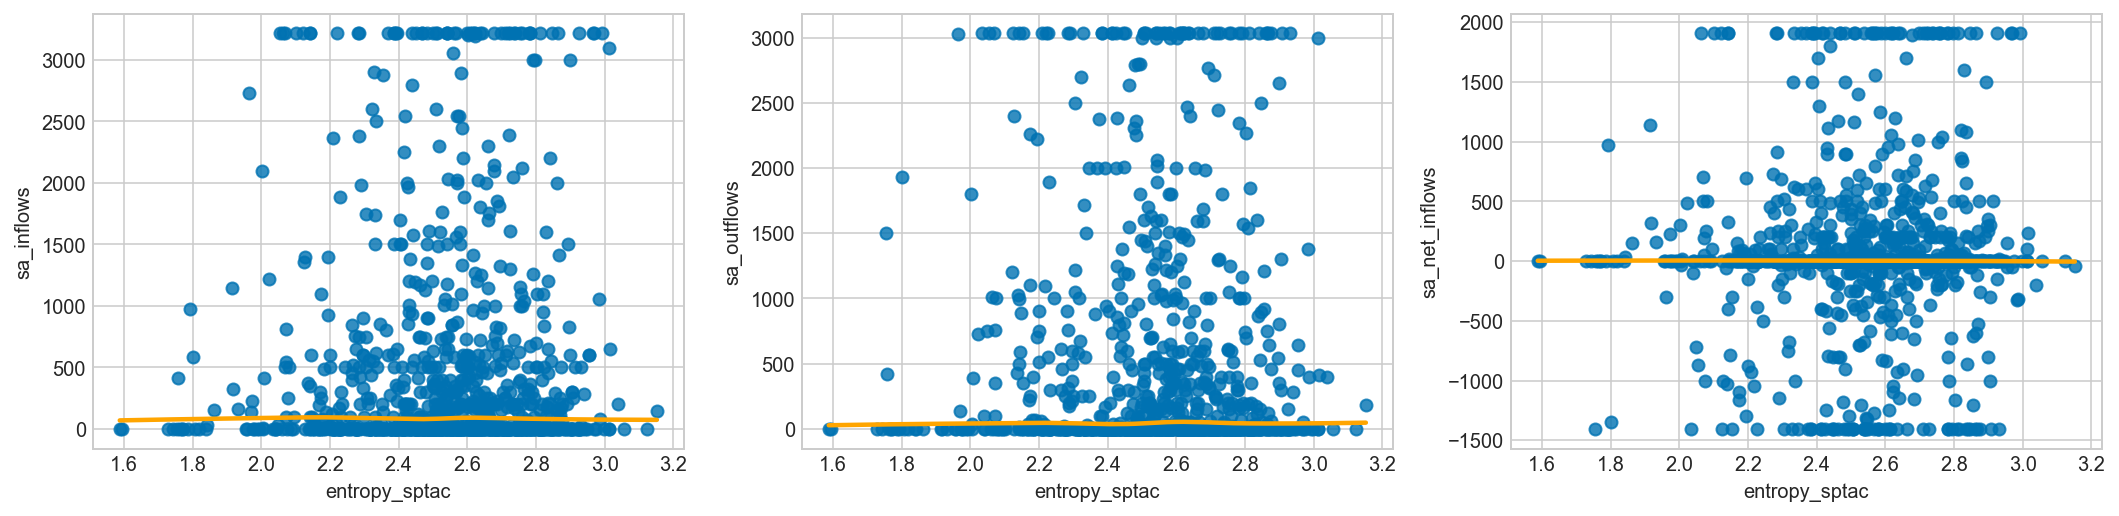

In [63]:
regplot(df, "sa_[oin]", "entropy", winsorise_kws=dict(pct=5))

## Results

### Scaled inflows

In [74]:
data = df
y = data["sa_scaled_inflows"]
tag_spend = list(df.filter(like="tag_spend").columns)
full_controls = ["log_monthly_spend"] + tag_spend[:-1]

#### Fixed effects

In [75]:
b = lm.PanelOLS(
    y,
    data["entropy_sptac"],
    entity_effects=True,
    time_effects=True,
).fit()
ba = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_income"]],
    entity_effects=True,
    time_effects=True,
).fit()
bd = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_monthly_spend"]],
    entity_effects=True,
    time_effects=True,
).fit()
be = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + tag_spend[:-1]],
    entity_effects=True,
    time_effects=True,
).fit()
bf = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit()
bg = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bh = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)
bi = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bj = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)


lm.panel.compare([b, ba, bd, be, bf, bg, bh, bi, bj], stars=True)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8
Dep. Variable,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,107296,107296,107296,107296,107296,107296,107296,107296,107296
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered,Clustered,Clustered,Clustered
R-squared,9.548e-06,0.0005,0.0018,0.0002,0.0018,0.0018,0.0019,0.0040,0.0122
R-Squared (Within),9.284e-06,0.0005,0.0018,0.0003,0.0019,0.0019,0.0019,0.0017,0.0015
R-Squared (Between),-0.1107,-13.844,-3.5250,0.0934,-4.7574,-4.7574,-4.7990,-4.9851,0.1175
R-Squared (Overall),-0.0108,-1.3933,-0.3635,0.0090,-0.4885,-0.4885,-0.4926,-0.5107,0.0122
F-statistic,0.9901,28.384,92.464,2.8433,19.196,19.196,19.846,42.757,132.48
P-value (F-stat),0.3197,0.0000,0.0000,0.0024,0.0000,0.0000,0.0000,0.0000,0.0000


#### Pooled

In [71]:
full_controls = ["log_income", "age", "female", "log_monthly_spend"] + tag_spend

a = lm.PanelOLS(y, sm.add_constant(data["entropy_sptac"])).fit()
aa = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "log_income"]])).fit()
ab = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "age"]])).fit()
ac = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "female"]])).fit()
ad = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "log_monthly_spend"]])).fit()
ae = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + tag_spend[:-1]])).fit()
af = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + full_controls])).fit()
ag = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + full_controls])).fit(
    cov_type="clustered", cluster_entity=True
)


lm.panel.compare([a, aa, ab, ac, ad, ae, af, ag], stars=True)

,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7
Dep. Variable,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,107296,107296,107296,107296,107296,107296,107296,107296
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered
R-squared,2.985e-05,9.394e-05,0.0014,0.0002,0.0037,0.0011,0.0069,0.0069
R-Squared (Within),-4.12e-05,9.208e-05,-3.02e-05,-5.145e-05,0.0018,1.925e-05,0.0025,0.0025
R-Squared (Between),0.0006,0.0005,0.0193,0.0025,0.0252,0.0124,0.0618,0.0618
R-Squared (Overall),2.985e-05,9.394e-05,0.0014,0.0002,0.0037,0.0011,0.0069,0.0069
F-statistic,3.2024,5.0403,77.068,8.4124,197.00,12.888,52.893,52.893
P-value (F-stat),0.0735,0.0065,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000


### Total inflows

In [72]:
data = df
y = data["sa_inflows"]
tag_spend = list(df.filter(like="tag_spend").columns)
full_controls = ["log_income", "log_monthly_spend"] + tag_spend[:-1]

### Fixed effects

In [73]:
b = lm.PanelOLS(
    y,
    data["entropy_sptac"],
    entity_effects=True,
    time_effects=True,
).fit()
ba = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_income"]],
    entity_effects=True,
    time_effects=True,
).fit()
bd = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_monthly_spend"]],
    entity_effects=True,
    time_effects=True,
).fit()
be = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + tag_spend[:-1]],
    entity_effects=True,
    time_effects=True,
).fit()
bf = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit()
bg = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bh = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)
bi = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bj = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)


lm.panel.compare([b, ba, bd, be, bf, bg, bh, bi, bj], stars=True)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8
Dep. Variable,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,107296,107296,107296,107296,107296,107296,107296,107296,107296
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered,Clustered,Clustered,Clustered
R-squared,2.97e-06,3.711e-05,0.0009,8.9e-05,0.0009,0.0009,0.0009,0.0053,0.0075
R-Squared (Within),3.935e-06,4.764e-05,0.0009,9.283e-05,0.0009,0.0009,0.0009,0.0006,0.0002
R-Squared (Between),-0.0186,-0.1242,-0.8894,-0.0112,-1.2358,-1.2358,-1.2670,-7.5494,0.0558
R-Squared (Overall),-0.0035,-0.0277,-0.1835,-0.0021,-0.2537,-0.2537,-0.2600,-1.5241,0.0075
F-statistic,0.3080,1.9241,44.459,1.0255,8.5301,8.5301,8.9177,51.709,73.813
P-value (F-stat),0.5789,0.1460,0.0000,0.4164,0.0000,0.0000,0.0000,0.0000,0.0000


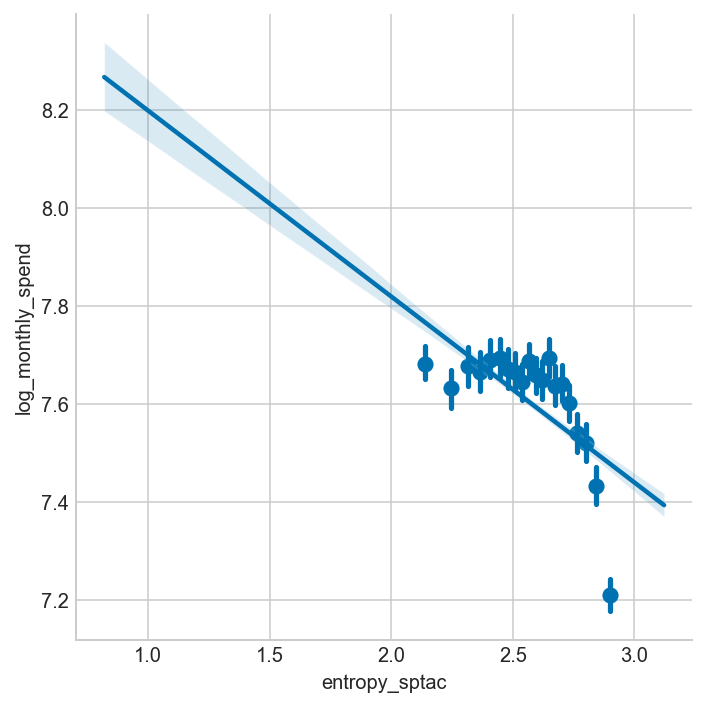

In [96]:
sns.lmplot(
    data=df.sample(frac=0.3), x="entropy_sptac", y="log_monthly_spend", x_bins=20
)